In [1]:
.mySampleScoreArrangerFn=function(inputPath){
  #This function reads in the sample scores (between 0 and 1)
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/classification_perm/"
  # inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

  resCombined=list()
  # tmpFiles=list.files(inputPath)
  tmpFiles = read.table(paste0(inputPath,"dataList.txt"))
  path=unlist(strsplit(inputPath,"/"))
  path=path[-length(path)]
  path=paste(path,collapse = "/")
  path=paste0(path,"/")
  # tmpFiles = as.vector(tmpFiles)
  if((length(tmpFiles))!=25){
    print(paste("caution: number of files is",(length(tmpFiles$V1))))
  }
  
  for(i in 1:(length(tmpFiles$V1))){
    # 
    # strsplit(status,"_")

    load(paste0(path,tmpFiles$V1[i],"results.rda"))
    
    tmp=result$ROCdf
    
    resdf=list()
    for(j in 1:length(tmp)){
      #print(j)
      tmpdf=tmp[[j]][[1]]
      tmpdf$status=tmp[[j]][[2]]
      colnames(tmpdf)=c("sampleName","real","estimated","status")
      resdf=c(resdf,list(tmpdf))
    }
    resdf=do.call("rbind",resdf)
    resdf=resdf[!duplicated(paste0(resdf$sampleName,"_",resdf$status)),]
    resCombined=c(resCombined,list(resdf))
  }
  
  return(resCombined)
}
.myClassificationEvaluationFn=function(testLabelsHat,testLabels){
  require(PRROC,quietly=T)
  require(pROC,quietly=T)
  
  finalResPR=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)$auc.integral
  finalResROC=as.numeric(roc(response=testLabels,predictor=as.vector(testLabelsHat))$auc)
  
  return(list(ROC=finalResROC,PR=finalResPR,ROCdata=roc(response=testLabels,predictor=as.vector(testLabelsHat)),PRdata=pr.curve(scores.class0=testLabelsHat,weights.class0=testLabels)))
}
.myResultOrganizerFn=function(inputPath,countThr=NULL,replaceZero=F){
  #results with number of folds less than the countThr are set to zero
  #zeros can be replaced with 0.5 (ROC and PR)
  load(inputPath)
  inputData=ROCres
  
  if(is.null(countThr)){
    countThr=max(inputData[[2]])
  }
  
  inputData[[1]][inputData[[2]]<countThr]=0
  if(replaceZero){
    inputData[[1]][inputData[[1]]==0]=0.5
  }
  res=inputData[[1]]
  
  thr=0
  if(replaceZero){
    thr=0.5
  }
  x=apply(res,1,function(x) sum(x==thr))
  res=res[which(x<(ncol(inputData[[1]])-1)),]
  return(res)
}

In [2]:
library(ggplot2)
library(reshape2)
library(limma)
library(gplots)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




test

In [3]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red",'purple')
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1410   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8908918        0.9022770        0.8946869        0.8927894 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8880455        0.8946869        0.8937381        0.8937381 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8937381        0.8913662        0.8913662        0.8951613 


pdf 
  2

Saving 7 x 7 in image



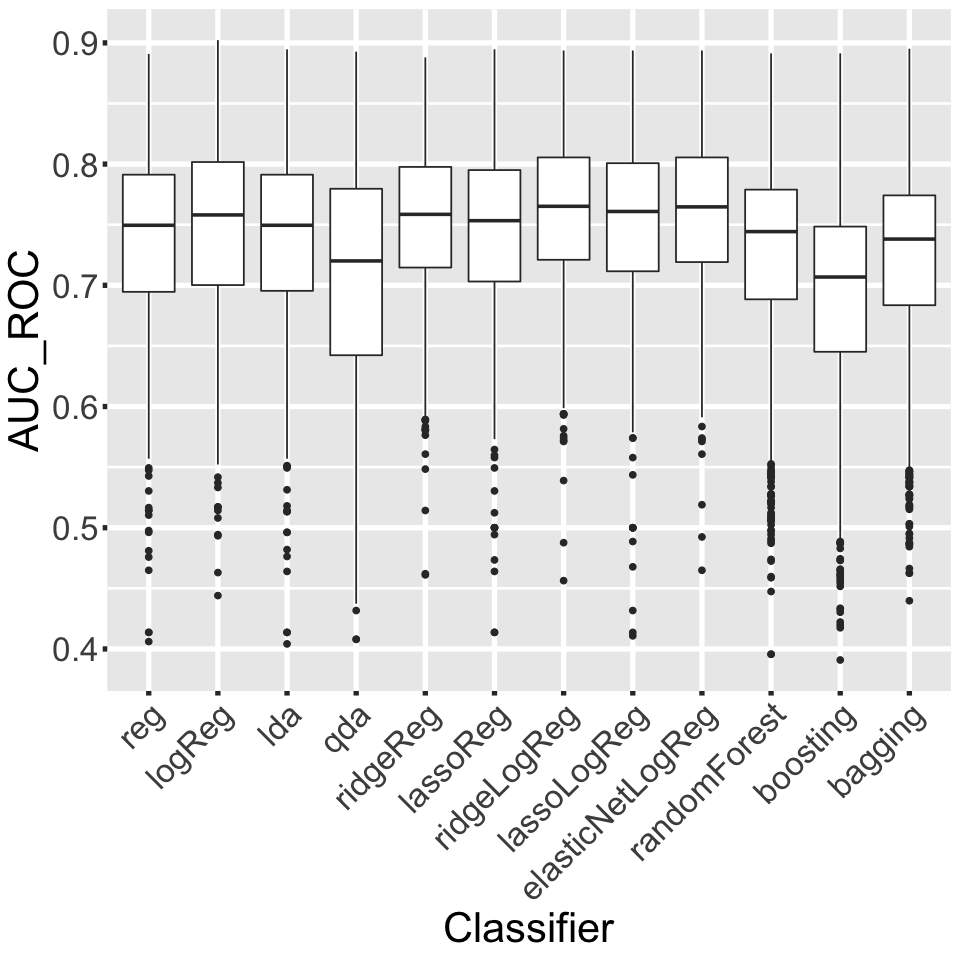

In [4]:
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
temp_data=melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
# pdf(file=paste0(inputPath,"test_boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
ggsave(paste0(inputPath,"myplot.png"))


# main

In [5]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/"
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/"

inputROCthr=0.7
inputROCPower=2
colorset=c("black","red")
wCompleteDS=F
# load(paste0(inputPath,"ResultsArranged.rda"))
weightsROC=.myResultOrganizerFn(paste0(inputPath,"ResultsArranged.rda"),replaceZero = T)
load(paste0(inputPath,"ResultsArranged.rda"))
PRs=PRres[[1]]
PRs=PRs[row.names(PRs) %in% row.names(weightsROC),]
PRs_counts=PRres[[2]]
PRs_counts=PRs_counts[row.names(PRs_counts) %in% row.names(weightsROC),]
PRs=PRs[,-which(colnames(PRs)=="sqda")]
PRs_counts=PRs_counts[,-which(colnames(PRs_counts)=="sqda")]

ROCs=ROCres[[1]]
ROCs=ROCs[row.names(ROCs) %in% row.names(weightsROC),]
ROCs_counts=ROCres[[2]]
ROCs_counts=ROCs_counts[row.names(ROCs_counts) %in% row.names(weightsROC),]
ROCs=ROCs[,-which(colnames(ROCs)=="sqda")]
ROCs_counts=ROCs_counts[,-which(colnames(ROCs_counts)=="sqda")]

countThr=max(ROCs_counts)
slInd=as.data.frame(which(ROCs_counts<countThr,arr.ind = T))
slInd=unique(slInd$row)
weightsROC=weightsROC[-which(row.names(weightsROC) %in% row.names(ROCs_counts)[slInd]),]
ROCs=ROCs[-which(row.names(ROCs) %in% row.names(ROCs_counts)[slInd]),]
PRs=PRs[-which(row.names(PRs) %in% row.names(ROCs_counts)[slInd]),]
PRs_counts=PRs_counts[-which(row.names(PRs_counts) %in% row.names(ROCs_counts)[slInd]),]
ROCs_counts=ROCs_counts[-which(row.names(ROCs_counts) %in% row.names(ROCs_counts)[slInd]),]
if(sum(colnames(weightsROC)=="sqda")>0){
weightsROC=weightsROC[,-which(colnames(weightsROC)=="sqda")]
}

print("Number of models:")
print(dim(weightsROC))

print("max scores per classifier:")
print(apply(weightsROC,2,max))
pdf(file=paste0(inputPath,"boxplot.pdf"))
boxplot(weightsROC,legend = F)
dev.off()


[1] "Number of models:"
[1] 1320   12
[1] "max scores per classifier:"
             reg           logReg              lda              qda 
       0.8731897        0.8551711        0.8741877        0.8399541 
        ridgeReg         lassoReg      ridgeLogReg      lassoLogReg 
       0.8573805        0.8692222        0.8551384        0.8560352 
elasticNetLogReg     randomForest         boosting          bagging 
       0.8557890        0.8332094        0.8308230        0.8382445 


pdf 
  2

In [6]:
# inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
temp_data=melt(weightsROC)
colnames(temp_data) = c('var1', 'Classifier', 'AUC_ROC')
pdf(file=paste0(inputPath,"boxplot.pdf"), width = 4.5, height = 5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
dev.off()


pdf 
  2

Saving 7 x 7 in image



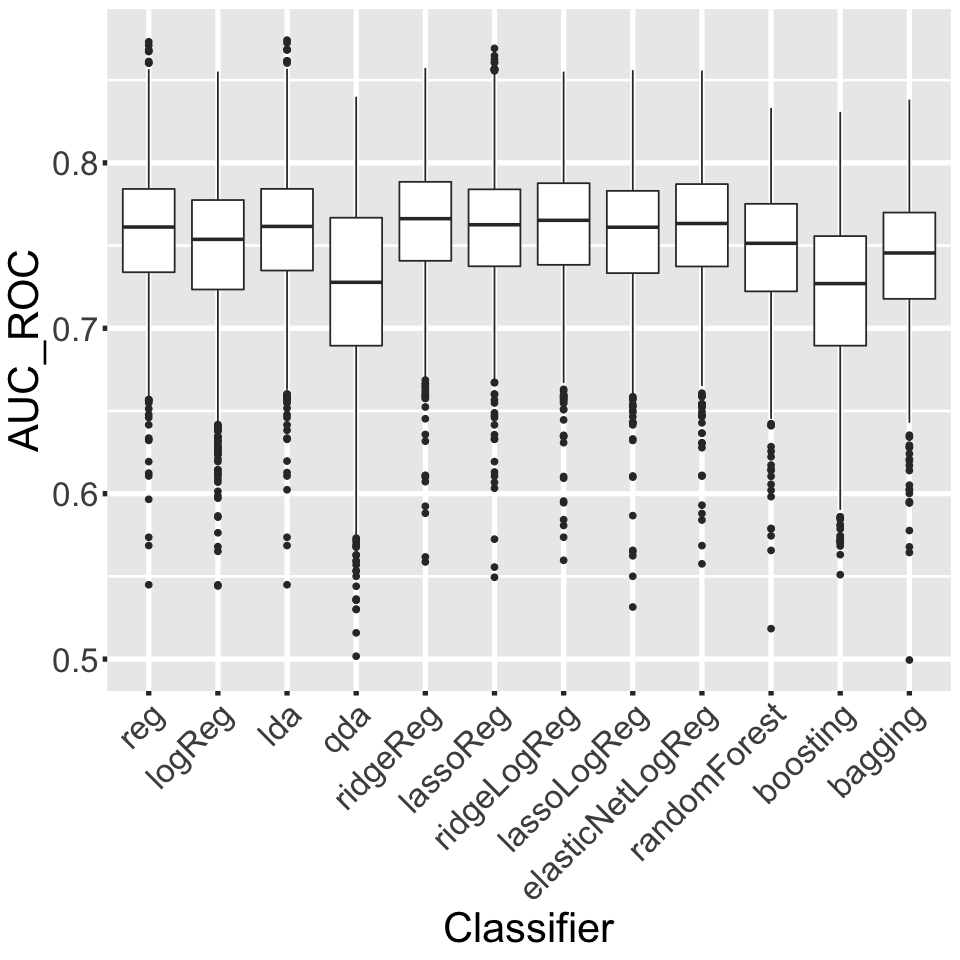

In [7]:
# png(file=paste0(inputPath,"boxplot.png"), width = 4, height = 4.5)
options(repr.plot.width = 8, repr.plot.height = 8)
ggplot(temp_data, aes(x=Classifier, y=AUC_ROC)) +
  geom_boxplot(outlier.size=1.5) +
  theme(axis.text.x = element_text(angle = 45,hjust=1),text = element_text(size = 25), element_line(size = 1.5))
# dev.off()
ggsave(paste0(inputPath,"boxplot.png"))

In [8]:
data=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_classificationSet_main/")

# dim(data) in train+ main "4209360 4
# dim(data) #in main 3748014
data=do.call("rbind",data)
status=gsub("^independent","^independent_1",data$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 25"


NULL

In [9]:
dim(data)

[1] 3748014       5

In [10]:
data_1=.mySampleScoreArrangerFn("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/")
# dim(data) in train+ main "4209360 4
# dim(data) in main 3748014
data_1=do.call("rbind",data_1)
status=gsub("^independent","^independent_1",data_1$status)
#removing the fold information from feature selection routes to allow the integration of results across folds
status=strsplit(status,"_")
status=unlist(lapply(status, function(x)paste(x[3:length(x)],collapse = "_")))
data_1$statusUpdated=status #statusUpdated: feature selection route without info on the fold
rm(status)

[1] "caution: number of files is 5"


In [11]:
data=rbind(data, data_1)

In [12]:
dim(data_1)

[1] 1140035       5

In [13]:
#weighting the scores based on the model's ROC

x=as.data.frame(weightsROC)
x$id=row.names(x)
x=reshape2::melt(x,by="id")

x=as.data.frame(weightsROC)
x$id=row.names(x)
x=reshape2::melt(x,by="id")

x2=strsplit(x$id,"_")
x2=unlist(lapply(x2,function(x)paste(x[2:length(x)],collapse = "_")))
x2=paste0(x2,"_",as.character(x$variable))
x2=gsub("independent","real",x2)
# x2=gsub("perm1","real",x2)
# x2=gsub("perm2","real",x2)
# x2=gsub("perm3","real",x2)
# x2=gsub("perm4","real",x2)
# x2=gsub("perm5","real",x2)
x$status=x2
                 
data=data[data$statusUpdated %in% x$status,]
x=x[x$status %in% data$statusUpdated,]


Using id as id variables

Using id as id variables



In [14]:
dim(data) # main 2772000 258240 3794580


[1] 3794580       5

In [15]:
x=x[,c("status","value")]
colnames(x)[2]="weightROC"
data=merge(data,x,by.x='statusUpdated',by.y="status")
rm(x)


In [16]:
# check for data abnormal, tmp is null is safe
tmp=as.data.frame(table(data$status[data$estimated>1]))
tmp
tmp=strsplit(as.character(tmp$Var1),"_")
tmp=unlist(lapply(tmp,function(x) x[length(x)]))

Freq
<int>


In [17]:
data=data[which(data$estimated>=0 & data$estimated<=1),]
data$id=paste0(data$statusUpdated,"_",data$sampleName)
data=list(data=data)
data$average=aggregate(estimated~id,data=data$data,FUN=mean)
                 

In [18]:
save(data, file="/Volumes/Work/Vahid_work/classification_newcode_data/tempero.rda")

In [19]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/tempero.rda")

data3=data$data[,c("id","sampleName","real","statusUpdated","weightROC")]
data3=data3[!duplicated(data3$id),]
data3=merge(data$average,data3,by="id")
data$average=data3
rm(data3)
                      
data$average$modWeightROC=data$average$weightROC-0.7  
data$average$modWeightROC[which(data$average$modWeightROC<0)]=0


In [20]:
length(data$average$weightROC)

[1] 3794580

In [21]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")

row.names(dataTest$data$weightsROC)=gsub("independent","real",row.names(dataTest$data$weightsROC))

x=dataTest$data$weightsROC
x=x[row.names(x) %in% row.names(dataMain$data$weightsROC),]

x2=as.data.frame(which(dataMain$data$weightsROC>0.8,arr.ind = T))

counter=0
slFeatures= c()
sl_models = c()
sl_model_main = c()
x2=x2[row.names(dataMain$data$weightsROC)[x2$row] %in% row.names(dataTest$data$weightsROC),]
for(i in 1:nrow(x2)){
  if(x[row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]]]>=0.75){
    counter=counter+1
    slFeatures=c(slFeatures,row.names(dataMain$data$weightsROC)[x2$row[i]])
    sl_models=c(sl_models, paste(row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))
  }
    sl_model_main=c(sl_model_main, paste(row.names(dataMain$data$weightsROC)[x2$row[i]],colnames(dataMain$data$weightsROC)[x2$col[i]], sep="_"))

}
# sl_models
name_refined = c()
for(i in 1:length(sl_models)){
  temp_name = unlist(strsplit(sl_models[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_refined = c(name_refined, temp_name)
}
name_main_refined = c()

for(i in 1:length(sl_model_main)){
  temp_name = unlist(strsplit(sl_model_main[i],"_"))
  temp_name = temp_name[-1]
  temp_name = paste(temp_name,collapse = "_")
  name_main_refined = c(name_main_refined, temp_name)
}
length(name_refined)
length(name_main_refined)

[1] 1076

[1] 1822

In [22]:
make_composite = TRUE        
if(make_composite){
print(paste0(sum(data$average$statusUpdated %in% name_refined), " subjects used to make composite model"))
    # in train+ main "258240 subjects used to make composite model"
data$average$modWeightROC[which(!data$average$statusUpdated %in% name_refined)] = 0.0
}
data$average$weightedEstimate=data$average$estimated*(data$average$modWeightROC)^2

[1] "258240 subjects used to make composite model"


[1] 258240

[1] 258240

[1] 3794580

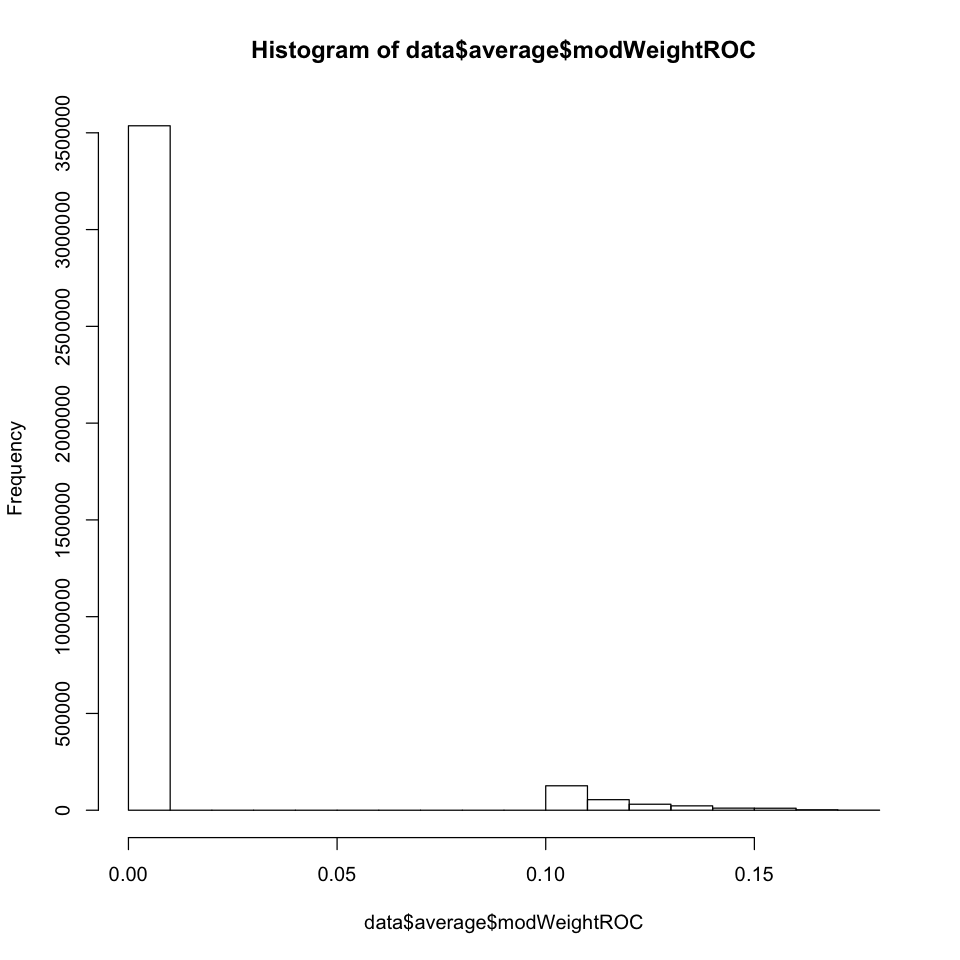

In [23]:
sum(data$average$statusUpdated %in% name_refined)
# sum(data$average$statusUpdated %in% name_main_refined)
sum(data$average$modWeightROC>0)
length(data$average$modWeightROC)
hist(data$average$modWeightROC)

In [24]:
data3=data$average
data3$dx=paste0(data3$statusUpdated,"_dx",data3$real)
tmp=data3[,c("dx","real")]
tmp=tmp[!duplicated(tmp$dx),]
data3med=aggregate(weightedEstimate~dx,data=data3,median)
data$overallSubjectMean=merge(data3med,tmp,by="dx")
rm(tmp,data3med,data3)
status=data$overallSubjectMean$dx
status=strsplit(status,"_")
status=unlist(lapply(status,function(x) paste(x[1:(length(x)-1)],collapse = "_")))
data$overallSubjectMean$status=status
rm(status)
data$average$group='test'
data$average$group[which(data$average$sampleName %in% dataMain$data$concensus$sampleName)]='main'


# output for main

In [25]:
# the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])
# the_mean

In [26]:
# data$concensus$real

In [27]:
tmp=dcast(data = data$average[which(data$average$group=='main'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
the_mean = mean(data$concensus$weightedEstimate[data$concensus$real==1])

length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC

df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

the_mean
df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]

pdf(file=paste0(inputPath,"Figure_2_heatmap.a.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
#eval(hm$call)
dev.off()


NULL

[1] 175

   
    FALSE TRUE
  0    81    1
  1    76   17
   
    FALSE TRUE
  0    80    2
  1    60   33
   
    FALSE TRUE
  0    77    5
  1    54   39
   
    FALSE TRUE
  0    75    7
  1    47   46


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8474954

$PR
[1] 0.8431402

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 82 controls (testLabels 0) < 93 cases (testLabels 1).
Area under the curve: 0.8475

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8431402 

    Area under curve (Davis & Goadrich):
     0.8429183 

    Curve not computed ( can be done by using curve=TRUE )



[1] 0.7151989

pdf 
  2

# output for test

In [28]:
tmp=dcast(data = data$average[which(data$average$group=='test'),],formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")
#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC
             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'orange')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]

pdf(file=paste0(inputPath,"Figure_2_heatmap.b.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 
dev.off()

NULL

[1] 65

   
    FALSE TRUE
  0    31    0
  1    27    7
   
    FALSE TRUE
  0    31    0
  1    21   13
   
    FALSE TRUE
  0    31    0
  1    18   16
   
    FALSE TRUE
  0    31    0
  1    14   20


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8785579

$PR
[1] 0.9123305

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 31 controls (testLabels 0) < 34 cases (testLabels 1).
Area under the curve: 0.8786

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.9123305 

    Area under curve (Davis & Goadrich):
     0.9123206 

    Curve not computed ( can be done by using curve=TRUE )



pdf 
  2


# output for all

In [29]:
head(data$average)

,id,estimated,sampleName,real,statusUpdated,weightROC,modWeightROC,weightedEstimate,group
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
1,cov_grn1_cppls_bagging_100,0.031,100,1,cov_grn1_cppls_bagging,0.7340489,0,0,test
2,cov_grn1_cppls_bagging_101,0.277,101,1,cov_grn1_cppls_bagging,0.7340489,0,0,main
3,cov_grn1_cppls_bagging_102,0.096,102,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
4,cov_grn1_cppls_bagging_104,0.124,104,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
5,cov_grn1_cppls_bagging_105,0.594,105,0,cov_grn1_cppls_bagging,0.7340489,0,0,test
6,cov_grn1_cppls_bagging_106,0.003,106,1,cov_grn1_cppls_bagging,0.7340489,0,0,main


In [30]:
# normalize the score with main and test

NULL

[1] 240

   
    FALSE TRUE
  0   112    1
  1   104   23
   
    FALSE TRUE
  0   111    2
  1    81   46
   
    FALSE TRUE
  0   106    7
  1    74   53
   
    FALSE TRUE
  0   105    8
  1    63   64


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8530416

$PR
[1] 0.8550665

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 113 controls (testLabels 0) < 127 cases (testLabels 1).
Area under the curve: 0.853

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8550665 

    Area under curve (Davis & Goadrich):
     0.8549046 

    Curve not computed ( can be done by using curve=TRUE )



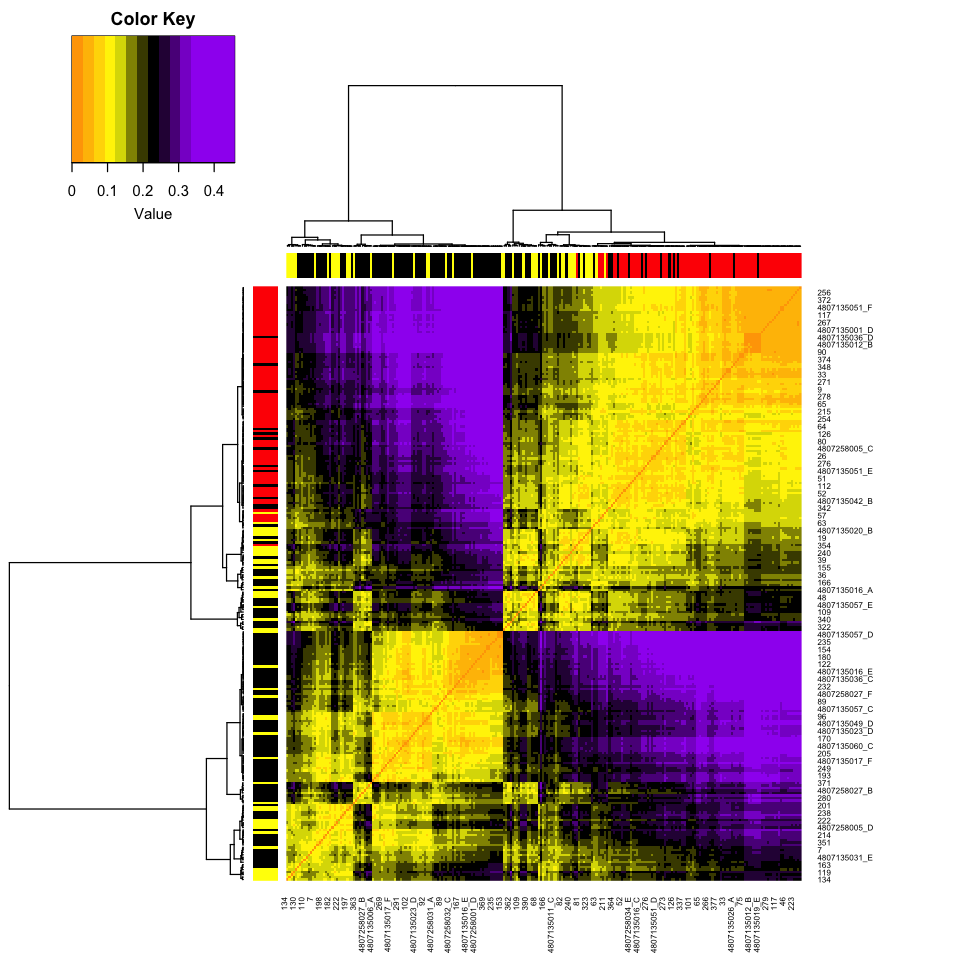

In [31]:
tmp=dcast(data = data$average, formula = statusUpdated~sampleName,fun.aggregate = sum,value.var = "weightedEstimate")

#eval(hm$call)
#   dev.off()
tmp2=data$average[,c("sampleName","real")]
tmp2=tmp2[!duplicated(tmp2$sampleName),]
             
data$concensus=apply(tmp[,-1],2,sum)
dim(data$concensus)
data$concensus=data.frame(sampleName=names(data$concensus),weightedEstimate=data$concensus,stringsAsFactors = F)
data$concensus=merge(data$concensus,tmp2,by="sampleName")

data$concensus$weightedEstimate=data$concensus$weightedEstimate - min(data$concensus$weightedEstimate)
data$concensus$weightedEstimate=data$concensus$weightedEstimate/max(data$concensus$weightedEstimate)
length(data$concensus$real)
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.9)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.8)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.75)))
print(table(data$concensus$real,data$concensus$weightedEstimate>quantile(data$concensus$weightedEstimate,0.7)))
print(.myClassificationEvaluationFn(data$concensus$weightedEstimate,data$concensus$real))

# data$weightsROC=weightsROC
data$PR_values=PRs
dataTandM=list(data=data, heatmap=hm)

             
df=data.frame(sampleName=colnames(tmp),isSel=1,stringsAsFactors = F)
df=df[!duplicated(df$sampleName),]
df=merge(df,data.frame(sampleName=data$average$sampleName,real=data$average$real,weightedEstimate=data$average$weightedEstimate, stringsAsFactors = F),by="sampleName")
df=df[!duplicated(df$sampleName),]
df=df[match(colnames(tmp)[-1],df$sampleName),]

df$category="other"
df$category[df$real==0]="TD"
df$category[df$real==1&data$concensus$weightedEstimate>=the_mean]="good"
df$category[df$real==1&data$concensus$weightedEstimate<the_mean]="poor"
labelsVector=df$category
labcol=rep("black",length(labelsVector))
colramp = colorRampPalette(c("orange","yellow","black","purple","purple"))(15)
scale="none"
main=""

xx=as.matrix(dist(t(tmp[,-1])))
xxx=cor(xx)
colorset=c("black","red",'yellow')

labcol[labelsVector=='TD']=colorset[1]
labcol[labelsVector=='good']=colorset[2]
labcol[labelsVector=='poor']=colorset[3]

#   pdf(file=paste0(inputPath,"heatmap.pdf"))
hm=heatmap.2(as.matrix(dist(t(tmp[,-1]))),
             col=colramp,
             RowSideColors = labcol,
             hclustfun=function(d) stats::hclust(d, method="ward.D2"),
             distfun=function(x) as.dist(1-cor(t(x))), 
             ColSideColors = labcol, 
             margins = c(5,10),
             scale=scale,main=main,trace="none",density.info=c("none")) 

In [32]:
library(tidyverse)  # data manipulation
library(cluster)    # clustering algorithms
library(factoextra)
# install.packages("ggpubr")
# install.packages("factoextra")
library(ggpubr)

library(factoextra)

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



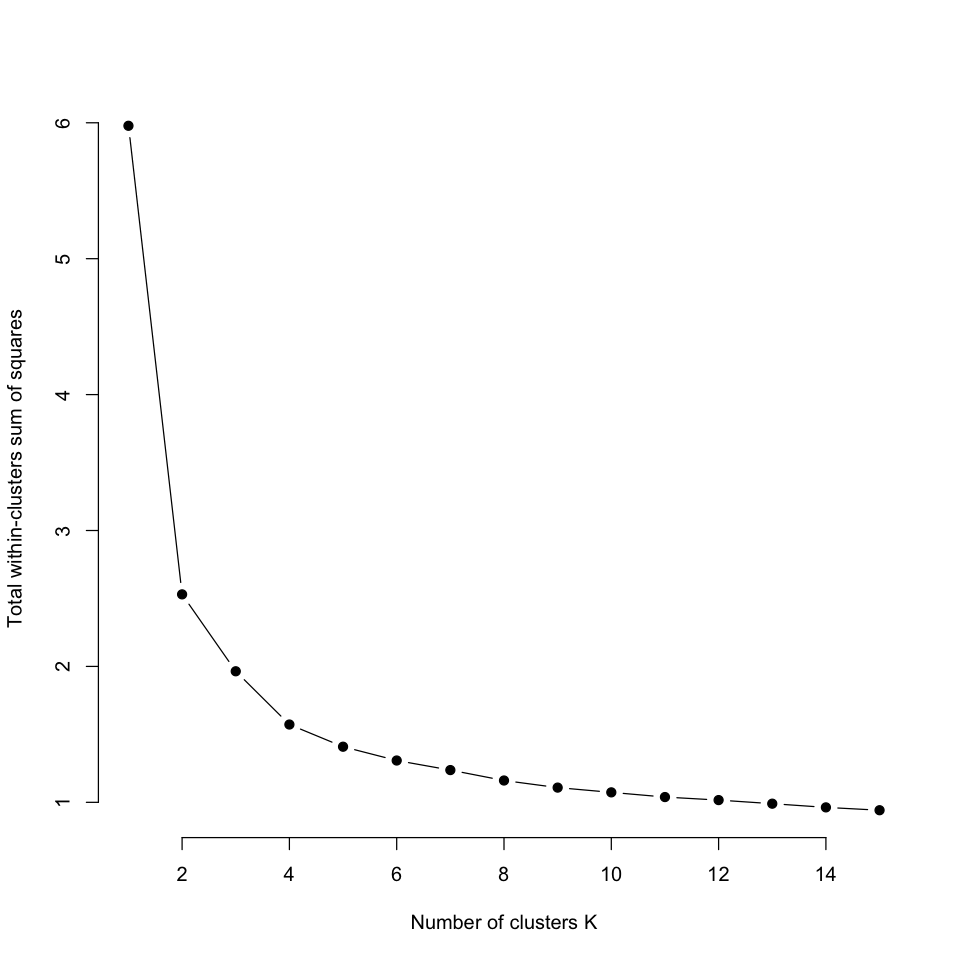

In [33]:
temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
temp_tmp = t(temp_tmp[,c(-1)])
res.km <- kmeans(temp_tmp, 4, nstart = 25)
# K-means clusters showing the group of each individuals
wss <- function(k) {
  kmeans(temp_tmp, k, nstart = 10 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:15

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

plot(k.values, wss_values,
       type="b", pch = 19, frame = FALSE, 
       xlab="Number of clusters K",
       ylab="Total within-clusters sum of squares")



In [34]:
# res.km$real=dMain$real

In [35]:
# temp_tmp = tmp[which(tmp$statusUpdated %in% name_refined),]
# temp_tmp = t(temp_tmp[,c(-1)])
# res.km <- kmeans(temp_tmp, 5, nstart = 25)
# p1 = fviz_cluster(res.km, data = temp_tmp,
#              geom = "point",
#              ellipse.type = "convex", 
#              ggtheme = theme_bw()
#              )


In [36]:
# p1$data$real=dMain$real

In [37]:
# ggplot(p1$data, aes(x=x, y=y)) +
#   geom_point(aes(shape=p1$data$cluster, color=p1$data$real),size=5)

# figure 3 x

In [38]:
head(dataTandM$data$concensus)

,sampleName,weightedEstimate,real
,<chr>,<dbl>,<dbl>
1,100,0.7308374,1
2,101,0.7625386,1
3,102,0.1388555,0
4,104,0.3343484,0
5,105,0.2520610,0
6,106,0.3924912,1


In [40]:
# save(dataLD,dataMain,dataLong,dataTest,file="/Volumes/Work/Vahid_work/classification_newcode_data/final_result_all.rda")
dataTandM$data$concensus$group='test'
dataTandM$data$concensus$group[which(dataTandM$data$concensus$sampleName %in% dataMain$data$concensus$sampleName)]='main'


# figure 3.x

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>
2,101,0.7625386,1,main,19,ASD,34.366,X3F5T
6,106,0.3924912,1,main,9,ASD,40.542,H3E8D
7,107,0.3284923,1,main,12,ASD,120.000,C2K6H
8,109,0.5800515,0,main,2,TD,34.825,Y2P2Z
9,110,0.4613390,0,main,1,TD,15.244,H7U8Q
10,111,0.9084604,1,main,13,ASD,30.292,M8K5X


[1] 0.7151989

[1] "mean"
[1] 0.7151989



	Pearson's product-moment correlation

data:  concensus_main$weightedEstimate and concensus_main$final_ADOS_CoSoTot
t = 8.7753, df = 173, p-value = 1.588e-15
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.4431311 0.6498344
sample estimates:
      cor 
0.5549916 


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



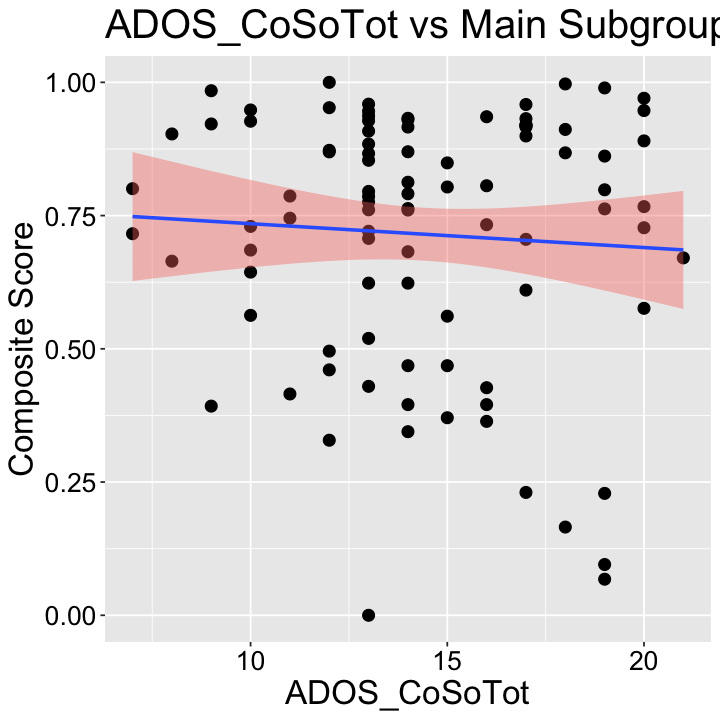

Saving 7 x 7 in image

Saving 7 x 7 in image



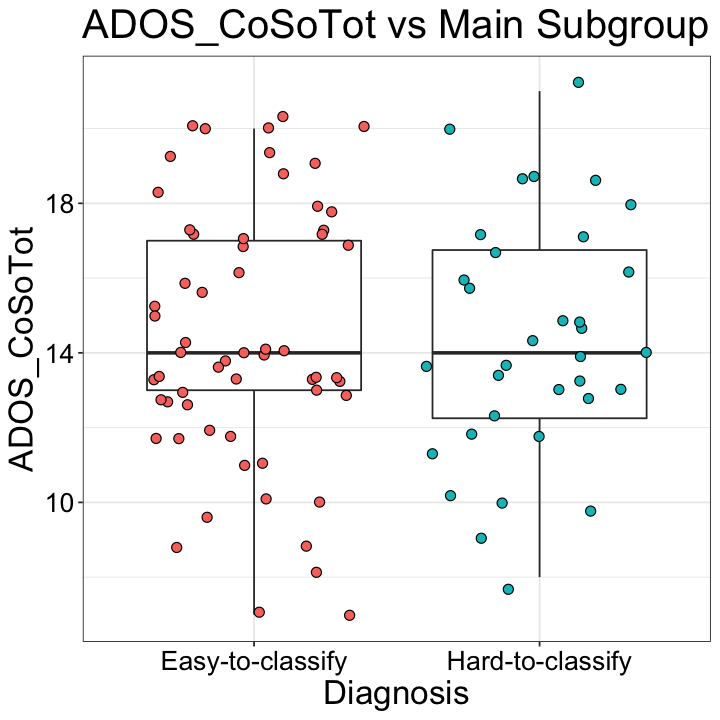

In [74]:
main_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_pheno_up.csv", row.names=1)
concensus_main = dataTandM$data$concensus[dataTandM$data$concensus$group=='main',]

concensus_main$final_ADOS_CoSoTot = main_pheno_up[concensus_main$sampleName, 'final_ADOS_CoSoTot']
concensus_main$recentDxJ_dxCode = main_pheno_up[concensus_main$sampleName, 'recentDxJ_dxCode']
concensus_main$recentDxJ_ageMo = main_pheno_up[concensus_main$sampleName, 'recentDxJ_ageMo']
concensus_main$subjectID = main_pheno_up[concensus_main$sampleName, 'subjectId']
head(concensus_main)
concensus_main$sampleLabel="TD"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="TD"]="TD"
# expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
print('mean')
print(mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"]))
the_mean = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
# the_mean = 0.75
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate>=the_mean]="Easy-to-classify"
concensus_main$sampleLabel[concensus_main$recentDxJ_dxCode=="ASD"&concensus_main$weightedEstimate<the_mean]="Hard-to-classify"
write.table(concensus_main, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/main_consensus.csv",sep = ",")
# cor(, )

cor.test(concensus_main$weightedEstimate,concensus_main$final_ADOS_CoSoTot,use="complete.obs") 

inputPath = "/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs Main Subgroup")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_corr.png"))
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"),width = 3.5, height = 4)


options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_main[concensus_main$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs Main Subgroup")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_MainSubgroup_box.pdf"))


,sampleName,weightedEstimate,real,group
,<chr>,<dbl>,<dbl>,<chr>
1,100,0.7308374,1,test
3,102,0.1388555,0,test
4,104,0.3343484,0,test
5,105,0.2520610,0,test
24,129,0.2260622,0,test
25,13,0.8522658,1,test


[1] 0.7151989


	Pearson's product-moment correlation

data:  concensus_test$weightedEstimate and concensus_test$final_ADOS_CoSoTot
t = 4.1048, df = 63, p-value = 0.0001185
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2426544 0.6324110
sample estimates:
      cor 
0.4593667 


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



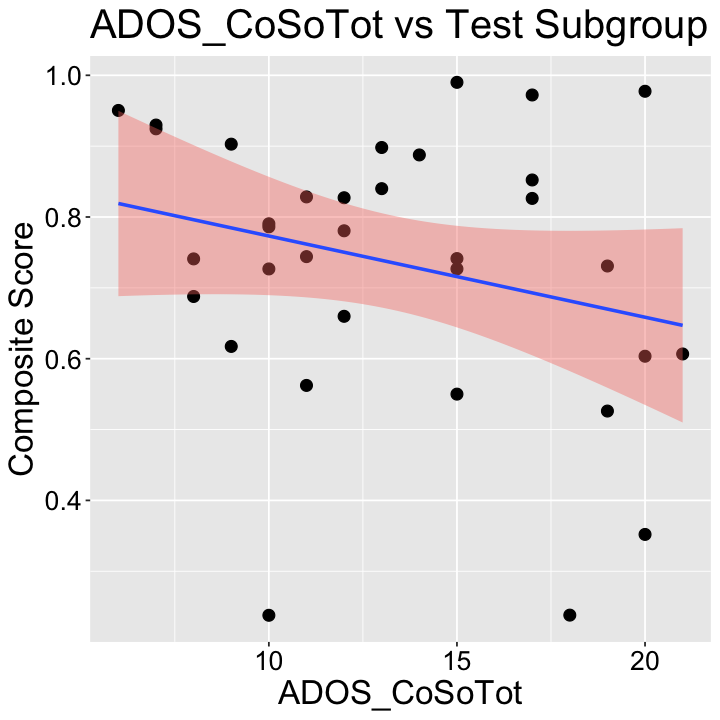

Saving 7 x 7 in image

Saving 7 x 7 in image



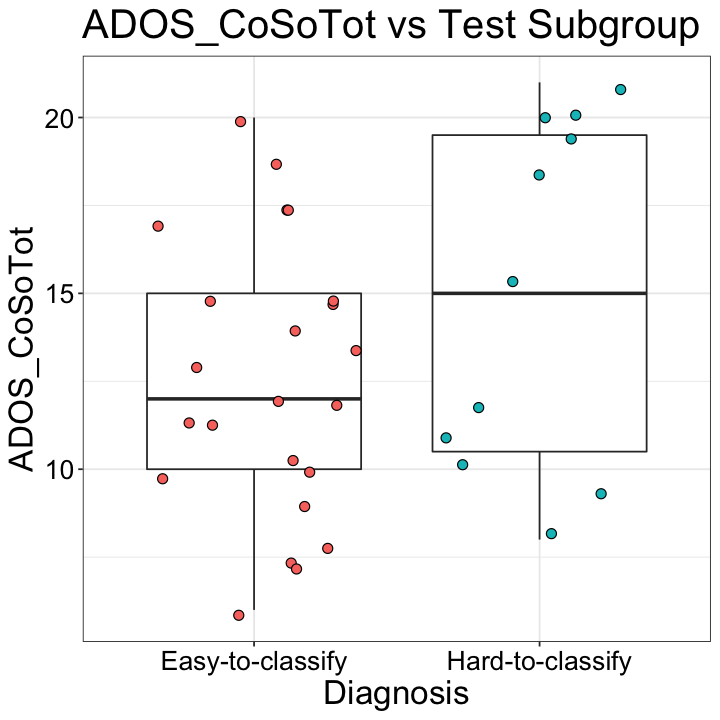

In [75]:
load("/Volumes/Work/Vahid_work/classification_newcode_data/final_testDataset_HT12_test/out1/data.rda")
write.table(data[["testInputData"]]@phenoData@data, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno.csv",sep = ",")

concensus_test = dataTandM$data$concensus[dataTandM$data$concensus$group=='test',]
head(concensus_test)

test_pheno_up <- read.csv("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_pheno_up.csv", row.names=1)
concensus_test$final_ADOS_CoSoTot = test_pheno_up[concensus_test$sampleName, 'final_ADOS_CoSoTot']

concensus_test$recentDxJ_dxCode = test_pheno_up[concensus_test$sampleName, 'recentDxJ_dxCode']
concensus_test$recentDxJ_ageMo = test_pheno_up[concensus_test$sampleName, 'recentDxJ_ageMo']
concensus_test$subjectID = test_pheno_up[concensus_test$sampleName, 'subjectId']
# head(concensus_test)
concensus_test$sampleLabel="TD"
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="TD"]="TD"
# expMain$sampleLabel[concensus_main$recentDxJ_dxCode=="other"]="TD"
the_mean
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate>=the_mean]="Easy-to-classify"
concensus_test$sampleLabel[concensus_test$recentDxJ_dxCode=="ASD"&concensus_test$weightedEstimate<the_mean]="Hard-to-classify"

write.table(concensus_test, file="/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/test_consensus.csv",sep = ",")
cor.test(concensus_test$weightedEstimate,concensus_test$final_ADOS_CoSoTot,use="complete.obs") 
###############


# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs Test Subgroup")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))

# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_test[concensus_test$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs Test Subgroup")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.png"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"))


`geom_smooth()` using formula 'y ~ x'

Saving 7 x 7 in image

`geom_smooth()` using formula 'y ~ x'



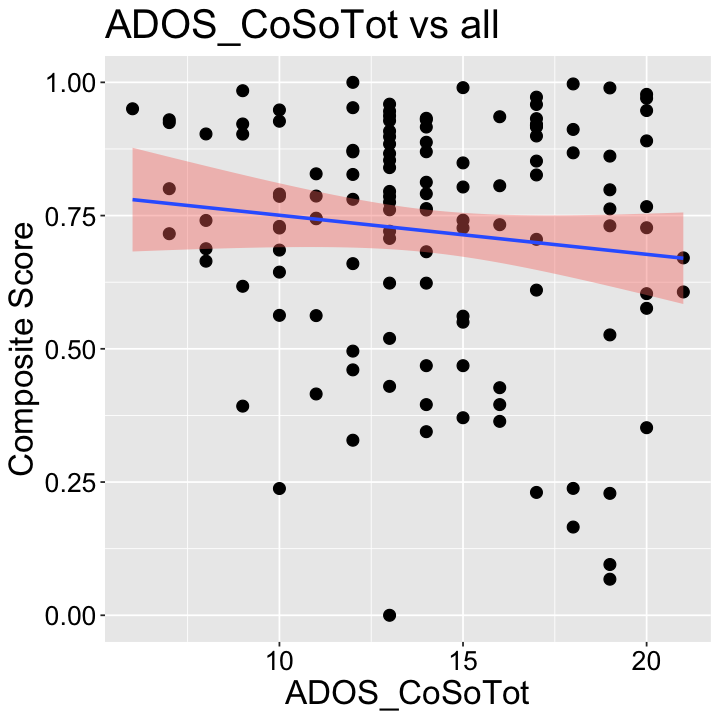

Saving 7 x 7 in image

Saving 7 x 7 in image



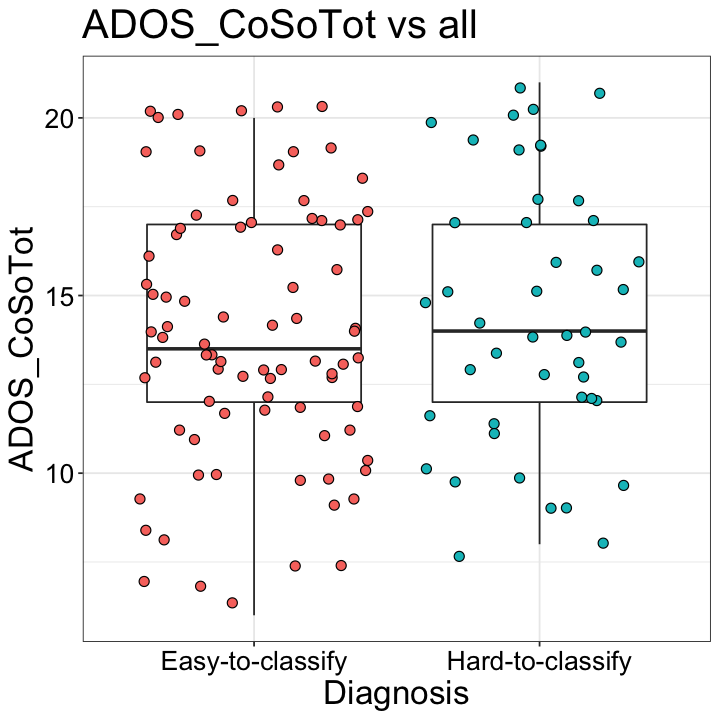

In [76]:
concensus_all=rbind(concensus_main, concensus_test)
# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(as.numeric(final_ADOS_CoSoTot),weightedEstimate, fill=recentDxJ_dxCode))+
  geom_point(size=3)+
  geom_smooth(method = "lm")+
  labs(title='Eval', x = "ADOS_CoSoTot", y='Composite Score')+
  ggtitle("ADOS_CoSoTot vs all")+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_corr.png"))

# pdf(file=paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_TestSubgroup_box.pdf"),width = 3.5, height = 4)
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(concensus_all[concensus_all$recentDxJ_dxCode %in% c("ASD","ASD Features"),],aes(sampleLabel,as.numeric(final_ADOS_CoSoTot)))+
  geom_boxplot(outlier.shape = NA)+theme_bw()+
geom_jitter(aes(fill=factor(sampleLabel)), width = 0.4,shape=21,size=2.5)+
ggtitle("ADOS_CoSoTot vs all")+
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 20))+xlab("Diagnosis")+ylab("ADOS_CoSoTot") 
# dev.off()
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.pdf"))
ggsave(paste0(inputPath,"Suppl_ADOS_CoSoTot_vs_all_box.png"))

[1] 0.7151989

Saving 7 x 7 in image

Saving 7 x 7 in image



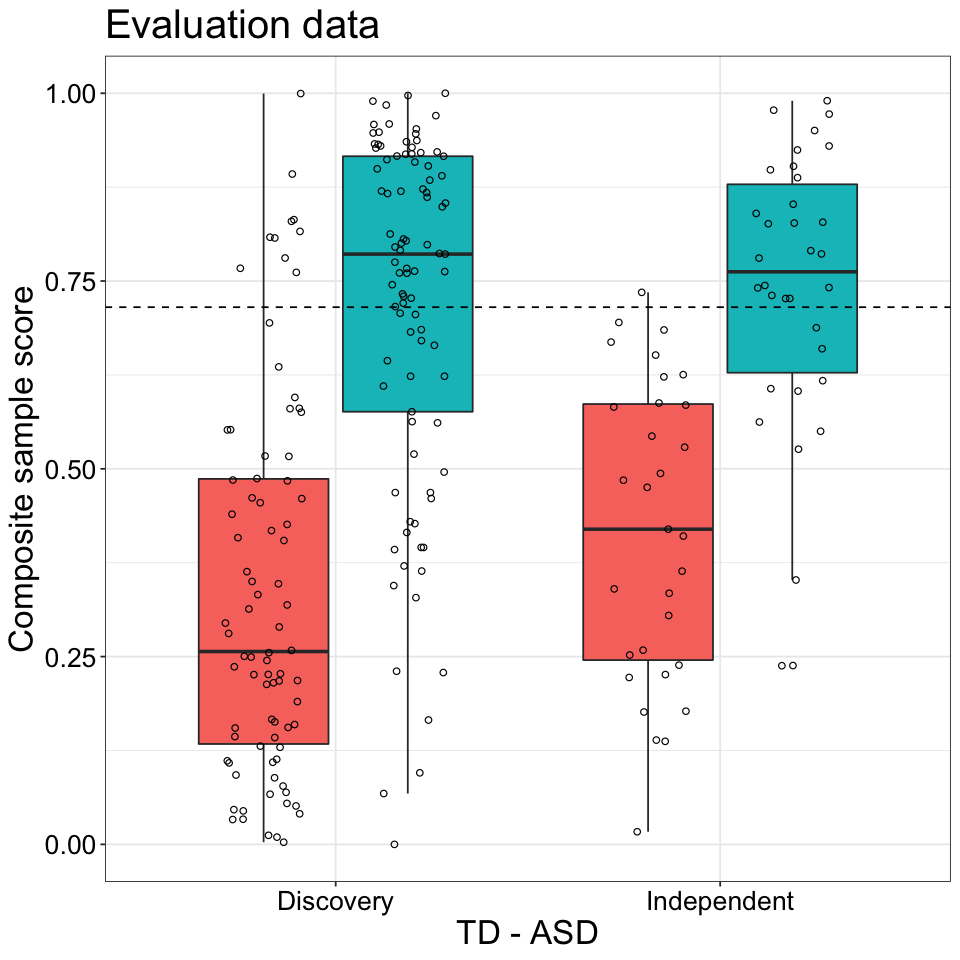

In [77]:
the_lint = mean(concensus_main$weightedEstimate[concensus_main$recentDxJ_dxCode=="ASD"])
the_lint
options(repr.plot.width = 8, repr.plot.height = 8)

ggplot(dataTandM$data$concensus,aes(fill=factor(real),y=weightedEstimate, x=group), )+
  geom_boxplot(outlier.shape = NA)+
  theme_bw()+geom_hline(yintercept = the_lint,linetype='dashed')+
  # geom_jitter(width = 0.2, alpha=0.6, shape=21)+
  geom_point(position=position_jitterdodge(dodge.width=0.75), shape=1)+
  ggtitle("Evaluation data")+
  theme(legend.position = "none", axis.text = element_text(color="black"), text = element_text(size = 20))+
  labs(x="TD - ASD",  y="Composite sample score")+
  scale_fill_discrete(name='Diagnosis', labels=c('TD','ASD'))+
  scale_x_discrete(labels=c("Discovery", "Independent"))

ggsave(paste0(inputPath, "Figure2_c.pdf"))
ggsave(paste0(inputPath, "Figure2_c.png"))

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



pdf 
  2

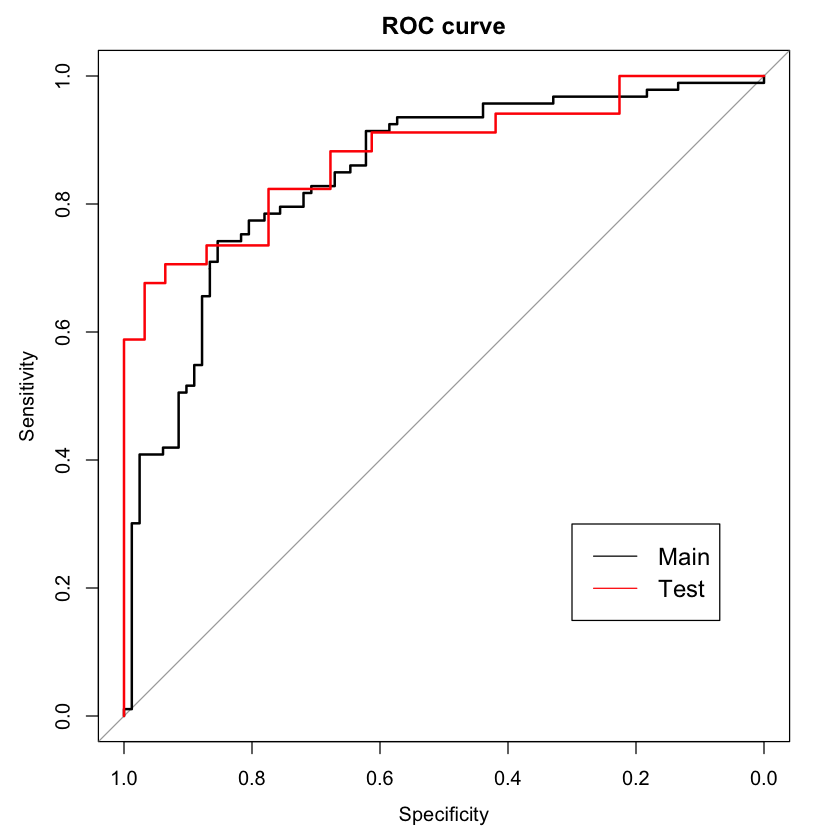

In [78]:
#AU-ROC of the composite scores
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis=.myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)
options(repr.plot.width = 7, repr.plot.height = 7)
plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Main", "Test"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
inputPath="/Volumes/Work/Vahid_work/classification_newcode_data/Figure_output/"
options(repr.plot.width = 6, repr.plot.height = 6)

pdf(file=paste0(inputPath,"figroc_curve.pdf"))
dMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='main'),]
tMain = dataTandM$data$concensus[which(dataTandM$data$concensus$group=='test'),]
Mainvis=.myClassificationEvaluationFn(dMain$weightedEstimate,dMain$real)

plot(Mainvis$ROCdata,xlim=c(1,0),ylim=c(0,1),main="ROC curve",col='black')
# dev.off()
# pdf(file=paste0(inputPath,"test_roc.pdf"))
Testvis=.myClassificationEvaluationFn(tMain$weightedEstimate,tMain$real)
lines(Testvis$ROCdata,xlim=c(1,0),ylim=c(0,1),col="red")
legend(0.3, 0.3, legend=c("Main", "Test"),
       col=c("black", "red"), lty=c(1,1), cex=1.2)
dev.off()

### Prenatal event

In [79]:
library(readxl)

my_data_1 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_mainConsensus_subjects.xlsx")
my_data_2 <- read_excel("/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/prenatalData_Bokan_testConsensus_subjects.xlsx")

In [80]:
head(my_data_1)

FormSerialId,EvalDate,SubjectId,P2F2,DOB,AgeMo,Sex,PregProb,FertDrugsNY,FertDrugs,⋯,UnusExpln,BrthWt_lb,BrthWt_oz,BrthLen_in,BrthHC_cm,Apgar1min,Apgar5min,HospStay,Prob1stMosNY,Prob1stMosExp
<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
PNB-00006,39584,R8S6F,MASI,2005-11-02,30.422999999999998,M,N,N,NULL,⋯,NULL,9,4,20,NULL,NULL,NULL,3,Y,Many colds- 2 yr old brother at home.
PNB-00009,39688,S4X9Y,ZEHU,2007-04-05,16.789000000000001,M,N,N,NULL,⋯,C-section after pushing for 3 hours. He wasn't in the birth canal straight+ got fever.,7,14,19,14,NULL,NULL,2,Y,"Jaundice, but not too bad. We didn't need to use the light."
PNB-00014,39549,E6E9P,CORE,2005-10-20,29.7,M,N,N,NULL,⋯,NULL,NULL,22,NULL,NULL,NULL,NULL,NULL,Y,"Jaundice, fever, weight loss, later developed laryngomalacia and birth mark like rash on R cheek"
PNB-00015,39834,Q2P7E,SALA,2007-08-14,17.280999999999999,M,-,-,NULL,⋯,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,-,NULL
PNB-00016,39541,M4L5B,MASA,2006-09-08,18.824999999999999,M,Y,Y,Injectable and cloned,⋯,NULL,6,14,20,NULL,8,9,3,N,NULL
PNB-00017,39825,P8M2M,OLHO,2006-10-31,26.414999999999999,M,Y,Y,IVF,⋯,please see NICU d/c summary,6,5,49.5,34,6,8,3,Y,NULL


In [81]:
head(concensus_main)

,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,subjectID,sampleLabel
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<fct>,<chr>
2,101,0.7625386,1,main,19,ASD,34.366,X3F5T,Easy-to-classify
6,106,0.3924912,1,main,9,ASD,40.542,H3E8D,Hard-to-classify
7,107,0.3284923,1,main,12,ASD,120.000,C2K6H,Hard-to-classify
8,109,0.5800515,0,main,2,TD,34.825,Y2P2Z,TD
9,110,0.4613390,0,main,1,TD,15.244,H7U8Q,TD
10,111,0.9084604,1,main,13,ASD,30.292,M8K5X,Easy-to-classify


In [82]:
prenatal = rbind(my_data_1, my_data_2)
# prenatal = my_data_1

the_mean = mean(concensus_main[concensus_main$recentDxJ_dxCode=="ASD",]$weightedEstimate)
# the_mean
# the_mean =0.74
sum(concensus_main$weightedEstimate>the_mean & concensus_main$real==0)
bloodId=concensus_main$sampleName
sampleNames=concensus_main$subjectID
scores=concensus_main$weightedEstimate
DX=concensus_main$real
df=data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F)
rm(sampleNames,scores,DX)
bloodId=concensus_test$sampleName
sampleNames=concensus_test$subjectID
scores=concensus_test$weightedEstimate
DX=concensus_test$real
df=rbind(df,data.frame(bloodId=bloodId,sampleNames=sampleNames,scores=scores,dx=DX,stringsAsFactors = F))

dim(df)

df=merge(df, prenatal, by.x="sampleNames", by.y="SubjectId")
df$category="other"
df$category[df$dx==0]="TD"
df$category[df$dx==1&df$scores>=the_mean]="good"
df$category[df$dx==1&df$scores<the_mean]="poor"

# df=my_data_3
# df = as.data.frame(df)
# table(df$LocAnes)
df$Hosp_tri=gsub("-",NA,df$Hosp_tri)
df$Hosp_tri = gsub("NULL",NA,df$Hosp_tri)
df$Hosp_med=gsub("-",NA,df$Hosp_med)
df$Hosp_med = gsub("NULL",NA,df$Hosp_med)
df$Surgery_tri=gsub("-",NA,df$Surgery_tri)
df$Surgery_tri = gsub("NULL",NA,df$Surgery_tri)

df$Surgery_med[which(df$Surgery_med=="C-section")]=NA
df$Surgery_med[which(df$Surgery_med=="c-section, vicadin (2 weeks)")]=NA
df$Surgery_med=gsub("-",NA,df$Surgery_med)
df$Surgery_med = gsub("NULL",NA,df$Surgery_med)

df$WtLoss_tri=gsub("-",NA,df$WtLoss_tri)
df$WtLoss_tri = gsub("NULL",NA,df$WtLoss_tri)
df$WtLoss_med=gsub("-",NA,df$WtLoss_med)
df$WtLoss_med=gsub("none",NA,df$WtLoss_med)
df$WtLoss_med=gsub("None",NA,df$WtLoss_med)
df$WtLoss_med = gsub("NULL",NA,df$WtLoss_med)
df$GenAnes=gsub("-",NA,df$GenAnes)
df$GenAnes=gsub("N",NA,df$GenAnes)
df$GenAnes = gsub("NULL",NA,df$GenAnes)
df$ConfBed_med=gsub("-",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none",NA,df$ConfBed_med)
df$ConfBed_med=gsub("none, bedrest",NA,df$ConfBed_med)
df$ConfBed_med = gsub("NULL",NA,df$ConfBed_med)
df$ConfBed_tri=gsub("-",NA,df$ConfBed_tri)
df$ConfBed_tri = gsub("NULL",NA,df$ConfBed_tri)
df$LocAnes=gsub("N",NA,df$LocAnes)
df$LocAnes=gsub("-",NA,df$LocAnes)
df$LocAnes = gsub("NULL",NA,df$LocAnes)
df$MornSick_med = gsub("none",NA,df$MornSick_med)
df$MornSick_med = gsub("None",NA,df$MornSick_med)
df$MornSick_med = gsub("n/a",NA,df$MornSick_med)
df$MornSick_med = gsub("N/A",NA,df$MornSick_med)
df$MornSick_med = gsub("no",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)
df$MornSick_med = gsub("N",NA,df$MornSick_med)
df$MornSick_med = gsub("NULL",NA,df$MornSick_med)
df$MornSick_med = gsub("-",NA,df$MornSick_med)

df$MornSick_tri = gsub("-",NA,df$MornSick_tri)
df$MornSick_tri = gsub("NULL",NA,df$MornSick_tri)

df$Nausea_tri= gsub("-",NA,df$Nausea_tri)
df$Nausea_tri = gsub("NULL",NA,df$Nausea_tri)
df$Nausea_med= gsub("-",NA,df$Nausea_med)
df$Nausea_med = gsub("NULL",NA,df$Nausea_med)
df$Swell_tri= gsub("-",NA,df$Swell_tri)
df$Swell_tri = gsub("NULL",NA,df$Swell_tri)

[1] 10

[1] 240   4

In [83]:
df

sampleNames,bloodId,scores,dx,FormSerialId,EvalDate,P2F2,DOB,AgeMo,Sex,⋯,BrthWt_lb,BrthWt_oz,BrthLen_in,BrthHC_cm,Apgar1min,Apgar5min,HospStay,Prob1stMosNY,Prob1stMosExp,category
<fct>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dttm>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A2H7X,4807135042_B,0.72971396,1,PNB-01001,39751,HUAB,2006-12-11,22.637,F,⋯,6,7,20,31,9,9,1,Y,Jaundice - Hunter had jaundice for 5 days.,good
A2Y4H,223,0.92704889,1,PNB-01153,40287,DEAR,2007-05-12,35.253,M,⋯,6,NULL,NULL,NULL,NULL,NULL,28,Y,Was on heart monitor for first month for apnea and jaundice,good
A3W6D,68,0.54999916,1,PNB-00048,1226448000,OLSE,2007-08-28,14.522,M,⋯,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,NULL,poor
A5G5M,80,0.82836638,1,PNB-00013,1233273600,BEED,2006-06-03,31.934,M,⋯,6,2,19.5,NULL,NULL,NULL,3,N,NULL,good
A5M2D,13,0.85226582,1,PNB-01012,1205971200,AUBA,2005-07-11,32.296,M,⋯,7,4,19,NULL,NULL,NULL,3,Y,"occasional unconsolable crying days after, no crying immediately after birth, color not good 1st day",good
A6L7X,25,0.78054541,1,PNB-01058,1210896000,DASO,2005-12-05,29.339,M,⋯,3,5,15.5,NULL,NULL,NULL,56,Y,"reflux, feeding tube, oxygen - CPAP, could not suck/swallow/breathe",good
A9P5P,363,0.31877801,0,PNB-10097,40665,KEMO,2009-12-30,16.033000000000001,M,⋯,3,11,NULL,NULL,NULL,NULL,54,Y,"breathing problems, reflex kidneys",TD
B2J9W,135,0.72062048,1,PNB-00130,40059,DACO,2008-03-26,17.280999999999999,M,⋯,7,2,NULL,NULL,NULL,NULL,3,Y,Jaundice horas despues de nacer,good
B4C2A,168,0.07765321,0,pnb-00121,40141,MAJE,2008-11-02,12.715,M,⋯,7,11,21,NULL,NULL,NULL,2,N,NULL,TD


In [84]:
sum(df$dx==1 & df$scores>=the_mean)

[1] 79

In [85]:
df = df[,c('sampleNames','category','Hosp_tri', 'Surgery_tri', 'ConfBed_tri', 'GenAnes', 'Nausea_tri','MornSick_tri','Swell_tri')]
df

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A2H7X,good,NA,NA,NA,NA,NA,NA,3
A2Y4H,good,NA,NA,NA,NA,NA,1,NA
A3W6D,poor,NA,NA,NA,NA,NA,NA,NA
A5G5M,good,NA,NA,NA,NA,NA,1,NA
A5M2D,good,NA,NA,NA,Y,3,3,NA
A6L7X,good,NA,3,3,NA,NA,1,NA
A9P5P,TD,NA,NA,NA,Y,NA,NA,NA
B2J9W,good,NA,NA,NA,NA,NA,NA,NA
B4C2A,TD,NA,NA,NA,Y,NA,1,NA


In [86]:
a_table = data.frame(col=c('easy-to-classify','hard-to-classify','TD'))#c('good','poor','TD'))
a_table$concensus = table(df$category)
t_positive = c()
t_negative = c()
for(i in row.names(df)){
if(sum(!is.na(df[i, c('Hosp_tri', 'Surgery_tri','ConfBed_tri','GenAnes')]))==0){
    t_positive=c(t_positive, 'NULL')
}
    else{
        t_positive=c(t_positive, 1)
    }
if(sum(!is.na(df[i, c('Nausea_tri','MornSick_tri','Swell_tri')]))==0){
    t_negative=c(t_negative, 'NULL')
}
    else{
        t_negative=c(t_negative, 1)
    }    
}
df$t_p = t_positive
df$t_n = t_negative

In [87]:
prenatal_concensuse = merge(df, concensus_all, by.x="sampleNames", by.y="subjectID")
prenatal_concensuse

sampleNames,category,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,t_p,t_n,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2H7X,good,NA,NA,NA,NA,NA,NA,3,NULL,1,4807135042_B,0.72971396,1,main,10,ASD,22.899,Easy-to-classify
A2Y4H,good,NA,NA,NA,NA,NA,1,NA,NULL,1,223,0.92704889,1,main,10,ASD,35.483,Easy-to-classify
A3W6D,poor,NA,NA,NA,NA,NA,NA,NA,NULL,NULL,68,0.54999916,1,test,15,ASD,36.205,Hard-to-classify
A5G5M,good,NA,NA,NA,NA,NA,1,NA,NULL,1,80,0.82836638,1,test,11,ASD,32.066,Easy-to-classify
A5M2D,good,NA,NA,NA,Y,3,3,NA,1,1,13,0.85226582,1,test,17,ASD,32.526,Easy-to-classify
A6L7X,good,NA,3,3,NA,NA,1,NA,1,1,25,0.78054541,1,test,12,ASD,43.598,Easy-to-classify
A9P5P,TD,NA,NA,NA,Y,NA,NA,NA,1,NULL,363,0.31877801,0,main,2,TD,47.376,TD
B2J9W,good,NA,NA,NA,NA,NA,NA,NA,NULL,NULL,135,0.72062048,1,main,13,ASD,34.760,Easy-to-classify
B4C2A,TD,NA,NA,NA,Y,NA,1,NA,1,1,168,0.07765321,0,main,5,TD,31.540,TD


In [88]:
for(term in c('Hosp_tri', 'Surgery_tri','ConfBed_tri', 'GenAnes',
                'Nausea_tri','MornSick_tri','Swell_tri','t_p','t_n')){
  print(term)
  print(table(df[,term], df$category))
  temp_table = table(df[,term],df$category)
  head(temp_table)
  a_vex=c()
  for(dx in c('good','poor','TD')){
    temp_col = temp_table[,dx]
    if (dim(temp_table)[1]==1){
      a_vex = c(a_vex,temp_col)
    }
  else{
    temp_col = temp_col[names(temp_col)!='NULL']
    a_vex = c(a_vex, sum(temp_col))
    }
}
  print(a_vex)
  a_table[,term] = a_vex
}

[1] "Hosp_tri"
   
    good poor TD
  1    0    1  1
  2    0    1  2
  3    5    3  3
[1] 5 5 6
[1] "Surgery_tri"
   
    good poor TD
  1    0    1  1
  2    0    2  1
  3    1    0  2
[1] 1 3 4
[1] "ConfBed_tri"
   
    good poor TD
  1    0    0  1
  2    3    3  4
  3    4    6  4
[1] 7 9 9
[1] "GenAnes"
   
    good poor TD
  Y   10   11 10
[1] 10 11 10
[1] "Nausea_tri"
   
    good poor TD
  1    3    1  7
  2    0    0  3
  3    1    1  2
[1]  4  2 12
[1] "MornSick_tri"
   
    good poor TD
  1   39   18 62
  2    2    0  1
  3    1    0  1
[1] 42 18 64
[1] "Swell_tri"
   
    good poor TD
  1    0    1  2
  2    2    0  3
  3   21    9 21
[1] 23 10 26
[1] "t_p"
      
       good poor TD
  1      19   20 24
  NULL   60   25 83
[1] 19 20 24
[1] "t_n"
      
       good poor TD
  1      52   24 70
  NULL   27   21 37
[1] 52 24 70


In [89]:
a_table

col,concensus,Hosp_tri,Surgery_tri,ConfBed_tri,GenAnes,Nausea_tri,MornSick_tri,Swell_tri,t_p,t_n
<fct>,<table>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
easy-to-classify,79,5,1,7,10,4,42,23,19,52
hard-to-classify,45,5,3,9,11,2,18,10,20,24
TD,107,6,4,9,10,12,64,26,24,70


In [57]:
a = 19
b = 20
c = 24
a1 = 79
b1 = 45
c1 = 107
fisher.test(rbind(c(a1-a, b1-b), c(a,b)))
fisher.test(rbind(c(a1-a, c1-c), c(a,c)))
fisher.test(rbind(c(c1-c, b1-b), c(c,b)))


	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, b1 - b), c(a, b))
p-value = 0.02655
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.071750 5.935452
sample estimates:
odds ratio 
  2.506221 



	Fisher's Exact Test for Count Data

data:  rbind(c(a1 - a, c1 - c), c(a, c))
p-value = 0.8609
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4351499 1.9367093
sample estimates:
odds ratio 
  0.913575 



	Fisher's Exact Test for Count Data

data:  rbind(c(c1 - c, b1 - b), c(c, b))
p-value = 0.01027
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.225115 6.190600
sample estimates:
odds ratio 
  2.746235 


# data tests for geo pref

In [90]:
library(readxl)

my_data_geo <- read_excel("/Volumes/Work/Autism/master_spread_sheet/Final GeoPref MasterSheet.xlsx", sheet='CompiledGeoPref_LongWide')


Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NV2713 / R2713C386: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in NZ2713 / R2713C390: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OB2713 / R2713C392: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in OD2713 / R2713C394: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in OE2713 / R2713C395: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in PT2713 / R2713C436: got 'NULL'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting date in PX2713 / R2713C440: got 'NULL'”
Warning message in 

In [91]:
the_geo_Table = my_data_geo[,c('Subject ID',"1ST_GOOD/OTHER_TIMEPOINT/EXCLUDE", "Total Fixation Duration",'% Fixation Geo')]
colnames(the_geo_Table) = c('subjectId', 'times', 'total','geo_per')

In [92]:
write.table(concensus_all, paste0(inputPath, "consensus.csv"), sep = ',')

In [93]:
concensus_all = rbind(concensus_main, concensus_test)
ddd = the_geo_Table[the_geo_Table$times =='1ST_GOOD',]
dddd = merge(ddd, concensus_all, by.x="subjectId", by.y="subjectID")
dddd

subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>
A2Y4H,1ST_GOOD,61.39,51.848835,223,0.92704889,1,main,10,ASD,35.483,Easy-to-classify
A3W6D,1ST_GOOD,54.14,3.380126,68,0.54999916,1,test,15,ASD,36.205,Hard-to-classify
A5G5M,1ST_GOOD,56.09,78.035300,80,0.82836638,1,test,11,ASD,32.066,Easy-to-classify
A9P5P,1ST_GOOD,59.26,3.914951,363,0.31877801,0,main,2,TD,47.376,TD
B2J9W,1ST_GOOD,48.11,43.275826,135,0.72062048,1,main,13,ASD,34.760,Easy-to-classify
B4C2A,1ST_GOOD,56.89,65.459659,168,0.07765321,0,main,5,TD,31.540,TD
B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.41772396,0,main,2,TD,44.715,TD
B4V3N,1ST_GOOD,46.34,36.167458,275,0.62326949,1,main,13,ASD,31.639,Hard-to-classify
B4Z9C,1ST_GOOD,35.22,24.247587,249,0.25857632,0,test,0,TD,37.749,TD


Saving 7 x 7 in image



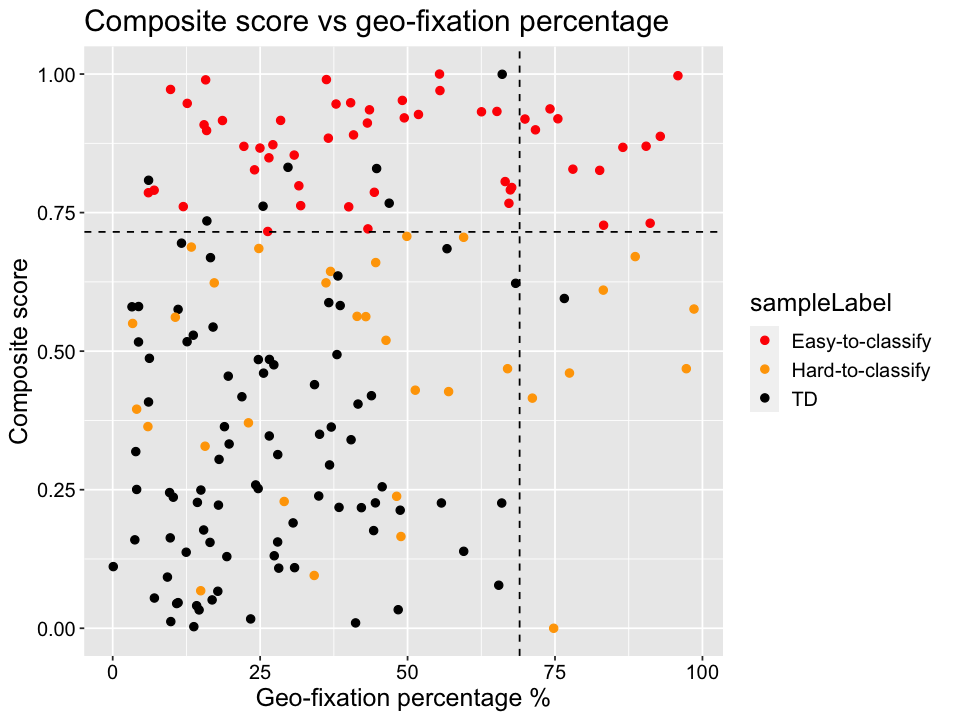

In [94]:
options(repr.plot.width = 8, repr.plot.height = 6)
ggplot(dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Composite score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "right",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Composite_score_vs_geo_fixation_percentage.pdf"))


In [95]:
dddd$geo_weighted = dddd$weightedEstimate
dddd$geo_weighted[dddd$geo_per>69]=1

In [96]:
.myClassificationEvaluationFn(dddd$weightedEstimate,dddd$real)
.myClassificationEvaluationFn(dddd$geo_weighted,dddd$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8578117

$PR
[1] 0.8429596

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.8578

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8429596 

    Area under curve (Davis & Goadrich):
     0.8427146 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8829588

$PR
[1] 0.8764032

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 89 controls (testLabels 0) < 84 cases (testLabels 1).
Area under the curve: 0.883

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8764032 

    Area under curve (Davis & Goadrich):
     0.8763979 

    Curve not computed ( can be done by using curve=TRUE )


In [97]:
.myClassificationEvaluationFn(dddd[dddd$group=='main', ]$geo_weighted,dddd[dddd$group=='main', ]$real)
.myClassificationEvaluationFn(dddd[dddd$group=='test', ]$geo_weighted,dddd[dddd$group=='test', ]$real)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8822581

$PR
[1] 0.880436

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 62 controls (testLabels 0) < 70 cases (testLabels 1).
Area under the curve: 0.8823

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.880436 

    Area under curve (Davis & Goadrich):
     0.8804272 

    Curve not computed ( can be done by using curve=TRUE )


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



$ROC
[1] 0.8888889

$PR
[1] 0.8680199

$ROCdata

Call:
roc.default(response = testLabels, predictor = as.vector(testLabelsHat))

Data: as.vector(testLabelsHat) in 27 controls (testLabels 0) < 14 cases (testLabels 1).
Area under the curve: 0.8889

$PRdata

  Precision-recall curve

    Area under curve (Integral):
     0.8680199 

    Area under curve (Davis & Goadrich):
     0.8679583 

    Curve not computed ( can be done by using curve=TRUE )


In [98]:
dddd[dddd$recentDxJ_dxCode %in% c("ASD",'TD'),]

,subjectId,times,total,geo_per,sampleName,weightedEstimate,real,group,final_ADOS_CoSoTot,recentDxJ_dxCode,recentDxJ_ageMo,sampleLabel,geo_weighted
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>
1,A2Y4H,1ST_GOOD,61.39,51.848835,223,0.92704889,1,main,10,ASD,35.483,Easy-to-classify,0.92704889
2,A3W6D,1ST_GOOD,54.14,3.380126,68,0.54999916,1,test,15,ASD,36.205,Hard-to-classify,0.54999916
3,A5G5M,1ST_GOOD,56.09,78.035300,80,0.82836638,1,test,11,ASD,32.066,Easy-to-classify,1.00000000
4,A9P5P,1ST_GOOD,59.26,3.914951,363,0.31877801,0,main,2,TD,47.376,TD,0.31877801
5,B2J9W,1ST_GOOD,48.11,43.275826,135,0.72062048,1,main,13,ASD,34.760,Easy-to-classify,0.72062048
6,B4C2A,1ST_GOOD,56.89,65.459659,168,0.07765321,0,main,5,TD,31.540,TD,0.07765321
7,B4J4L,1ST_GOOD,50.34,21.911005,4807135024_E,0.41772396,0,main,2,TD,44.715,TD,0.41772396
8,B4V3N,1ST_GOOD,46.34,36.167458,275,0.62326949,1,main,13,ASD,31.639,Hard-to-classify,0.62326949
9,B4Z9C,1ST_GOOD,35.22,24.247587,249,0.25857632,0,test,0,TD,37.749,TD,0.25857632


Saving 7 x 7 in image



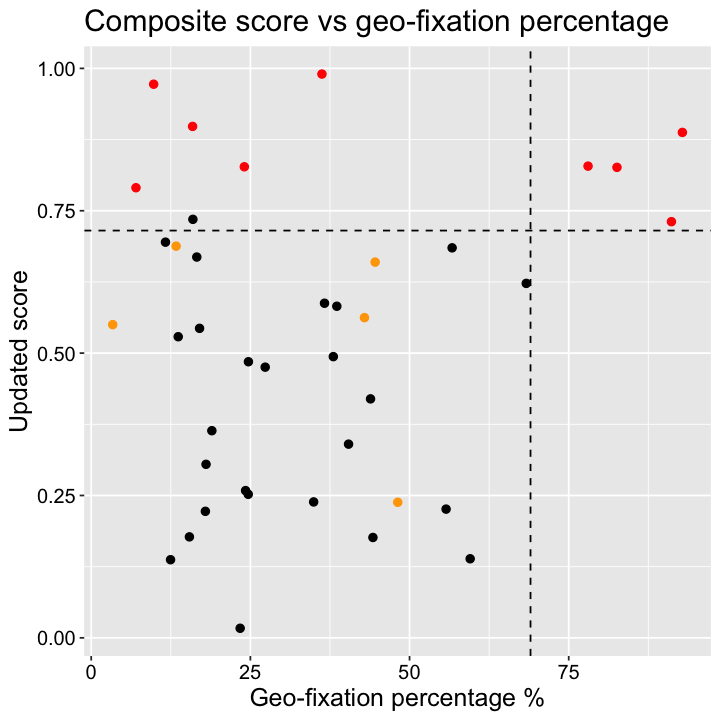

In [99]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_test.pdf"))

Saving 7 x 7 in image



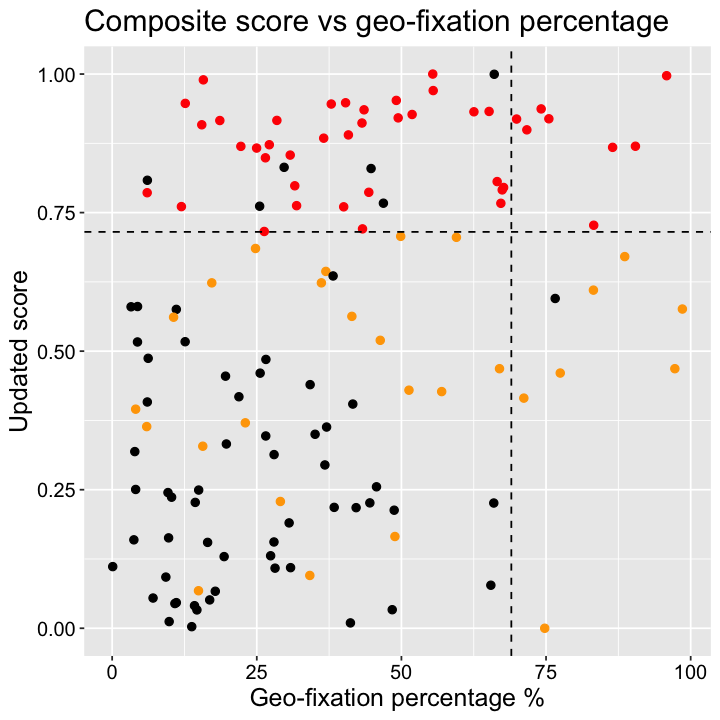

In [100]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main', ]
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=weightedEstimate, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Composite score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
  theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Original_score_vs_geo_fixation_percentage_main.pdf"))

[1] 132

Saving 7 x 7 in image



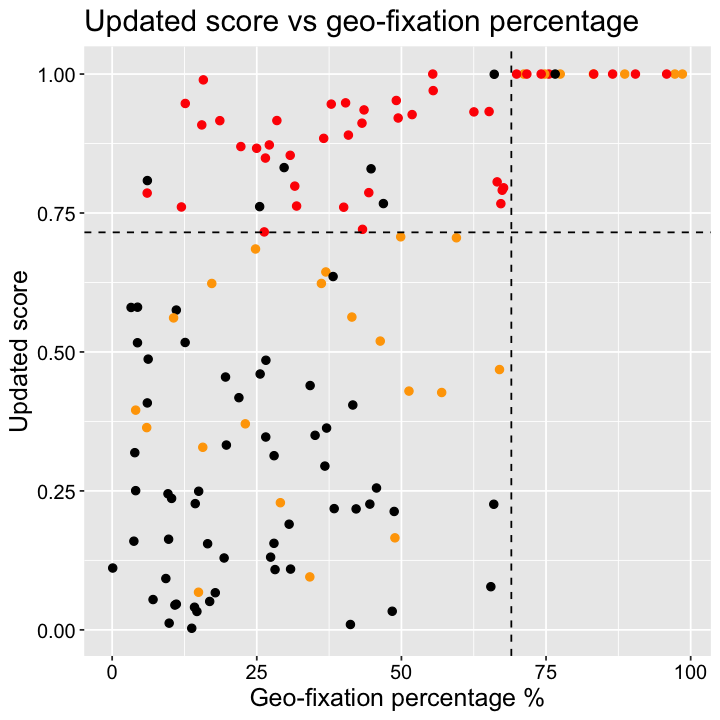

In [101]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_main = dddd[dddd$group=='main',]
nrow(dddd_main)
ggplot(dddd_main[dddd_main$recentDxJ_dxCode %in% c("ASD",'TD'),], aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none", axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Updated_score_vs_geo_fixation_percentage_main.pdf"))

[1] 41

Saving 7 x 7 in image



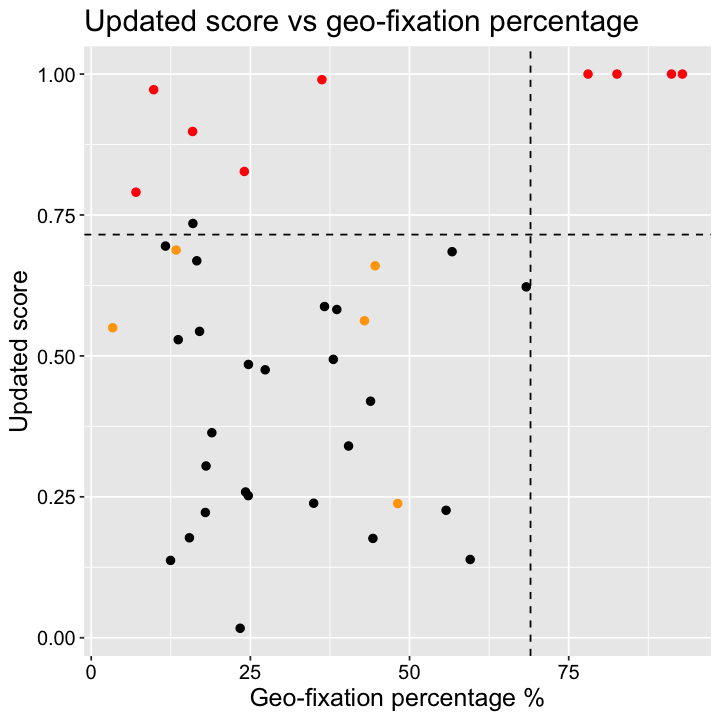

In [102]:
options(repr.plot.width = 6, repr.plot.height = 6)
dddd_test = dddd[dddd$group=='test', ]
nrow(dddd_test)
ggplot(dddd_test[dddd_test$recentDxJ_dxCode %in% c("ASD",'TD'),],aes(x=geo_per, y=geo_weighted, color=sampleLabel))+
# scale_fill_discrete()+
#   geom_smooth(method = "lm")+
   geom_point(size=2)+
   scale_color_manual(values = c('red','orange','black'))+
  labs(x = "Geo-fixation percentage %", y='Updated score')+
  ggtitle("Updated score vs geo-fixation percentage")+
  geom_hline(yintercept = the_mean,linetype='dashed')+
  geom_vline(xintercept = 69,linetype='dashed')+
#   scale_fill_discrete(color='sampleLabel')+
#   theme(legend.position = "none")
theme(legend.position = "none",axis.text = element_text(color="black"),text = element_text(size = 15))
ggsave(paste0(inputPath,"Updated_score_vs_geo_fixation_percentage_test.pdf"))

In [106]:
akk = read.csv('/Volumes/Work/Vahid_work/classification_newcode_data/Supplementary_data/data_classification_clinical_scores.csv')

cosmos = merge(akk, concensus_all[,c('subjectID','sampleLabel' )], by.x="subjectid", by.y="subjectID")

a = c('recentDxJ_ageMo',
      'final_ados_CoSoTot',
      'final_ados_RRTot',
      'final_ados_CoSoTotRRTot',
      'final_vine_ComTotal_DomStd',
      'final_vine_DlyTotal_DomStd',
      'final_vine_SocTotal_DomStd',
      'final_vine_MtrTotal_DomStd',
      'final_vine_AdapBehav_DomStd',
      'final_vine_DomStdTotal',
      'final_mullen_VRT',
      'final_mullen_FMT',
      'final_mullen_RLT',
      'final_mullen_ELT',
      'final_mullen_ELC_Std')
category = c('Easy-to-classify', 'Hard-to-classify', 'TD')
for(i in a){
    print(i)
    for(group in category){
        print(group)
        print(nrow(cosmos[cosmos$sampleLabel==group,]))
        print(mean(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
        print(sd(cosmos[cosmos$sampleLabel==group,i], na.rm = TRUE))
    }
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[2],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[2],i], cosmos[cosmos$sampleLabel==category[3],i]))
    print(t.test(cosmos[cosmos$sampleLabel==category[1],i], cosmos[cosmos$sampleLabel==category[3],i]))
}


[1] "recentDxJ_ageMo"
[1] "Easy-to-classify"
[1] 82
[1] 45.34087
[1] 21.2499
[1] "Hard-to-classify"
[1] 45
[1] 58.15416
[1] 37.28661
[1] "TD"
[1] 113
[1] 35.79913
[1] 10.8799

	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == category[2], i]
t = -2.1237, df = 60.047, p-value = 0.03782
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -24.8817348  -0.7448446
sample estimates:
mean of x mean of y 
 45.34087  58.15416 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[2], i] and cosmos[cosmos$sampleLabel == category[3], i]
t = 3.9554, df = 47.013, p-value = 0.0002562
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 10.98514 33.72490
sample estimates:
mean of x mean of y 
 58.15416  35.79913 


	Welch Two Sample t-test

data:  cosmos[cosmos$sampleLabel == category[1], i] and cosmos[cosmos$sampleLabel == cate